## Sistem preporuka polovnih automobila zasnovan na Two-Tower arhitekturi

Cilj ovog projekta je izgradnja sistema za preporuku polovnih automobila koji uči zajednički embedding prostor za korisnike i vozila koristeći Two-Tower neuronsku arhitekturu. Model povezuje sintetičke korisničke preferencije i karakteristike automobila kako bi identifikovao najrelevantnije preporuke na osnovu njihove sličnosti.


In [1]:
import re
import numpy as np
import pandas as pd

np.random.seed(42)

def extract_float(series: pd.Series) -> pd.Series:
    """
    Izvlaci prvi decimalni broj iz stringa (npr. '23.4 kmpl', '1248 CC')
    Ako nema broja, vraca NaN
    """
    s = series.astype(str)
    return pd.to_numeric(s.str.extract(r"(\d+\.?\d*)")[0], errors="coerce")

def parse_torque_to_nm(torque_series: pd.Series) -> pd.Series:
    """
     Izvlaci vrednost obrtnog momenta, ako je u kgm/kg-m, konvertuje u Nm
    """
    raw = torque_series.astype(str)
    val = pd.to_numeric(raw.str.extract(r"(\d+\.?\d*)")[0], errors="coerce")
    is_kgm = raw.str.contains(r"kgm|kg-m", case=False, na=False)
    val_nm = val.copy()
    val_nm.loc[is_kgm] = val_nm.loc[is_kgm] * 9.80665
    return val_nm

def extract_brand(name_series: pd.Series) -> pd.Series:
    """
    Brend je prva rec u nazivu automobila
    """
    s = name_series.astype(str).str.strip()
    return s.str.split().str[0].fillna("Unknown")


df = pd.read_csv("./data/car-details-v4.csv", low_memory=False)
df.head()


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Hyundai Grand i10 CRDi Asta Option,2013,270000,118000,Diesel,Individual,Manual,First Owner,24.0 kmpl,1120 CC,70 bhp,160Nm@ 1500-2750rpm,5.0
1,Hyundai Verna 1.6 SX,2013,420000,69000,Diesel,Individual,Manual,Third Owner,22.32 kmpl,1582 CC,126.32 bhp,259.8Nm@ 1900-2750rpm,5.0
2,Maruti Swift Dzire LXI,2015,434999,25000,Petrol,Individual,Manual,Second Owner,20.85 kmpl,1197 CC,83.14 bhp,115Nm@ 4000rpm,5.0
3,Hyundai Xcent 1.2 Kappa AT S Option,2015,400000,100000,Petrol,Individual,Automatic,First Owner,16.9 kmpl,1197 CC,81.86 bhp,113.75Nm@ 4000rpm,5.0
4,Maruti Swift Dzire VDI,2015,470000,110000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


In [2]:
df = df[
    [
        "name",
        "year",
        "selling_price",
        "km_driven",
        "fuel",
        "seller_type",
        "transmission",
        "owner",
        "mileage",
        "engine",
        "max_power",
        "torque",
        "seats",
    ]
].copy()

In [3]:
df["mileage"] = extract_float(df["mileage"])
df["engine"] = extract_float(df["engine"])
df["max_power"] = extract_float(df["max_power"])
df["torque_nm"] = parse_torque_to_nm(df["torque"])
df["seats"] = pd.to_numeric(df["seats"], errors="coerce")

name = df["name"].astype(str)

df["body_coupe"] = name.str.contains(
    r"Coupe|Sports|Roadster|Convertible|Cabrio|Cabriolet|TT|Z4|S2000|Mustang|GT\b",
    case=False,
    na=False,
).astype(int)

df["body_sedan"] = name.str.contains(
    r"\bSedan\b|Dzire|City|Verna|Civic|Corolla|Passat|Octavia|Jetta|C-Class|S-Class",
    case=False,
    na=False,
).astype(int)

df["body_suv"] = name.str.contains(
    r"Scorpio|Bolero|Fortuner|Safari|Innova|Jeep|XUV|Endeavour|Creta|Harrier|Hector|Duster",
    case=False,
    na=False,
).astype(int)

df["brand"] = extract_brand(df["name"])

premium_brands = {
    "Mercedes",
    "BMW",
    "Audi",
    "Lexus",
    "Jaguar",
    "Volvo",
    "Porsche",
    "Land",
    "Range",
}

df["is_premium_brand"] = df["brand"].isin(premium_brands).astype(int)
df.loc[name.str.contains(r"Land Rover", case=False, na=False), "is_premium_brand"] = 1
df.loc[name.str.contains(r"Range Rover", case=False, na=False), "is_premium_brand"] = 1

cat_cols = ["fuel", "seller_type", "transmission", "owner"]
for c in cat_cols:
    df[c] = (
        df[c]
        .astype(str)
        .replace({"nan": np.nan, "None": np.nan})
        .fillna("Unknown")
        .str.strip()
    )

for c in ["year", "selling_price", "km_driven"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["name", "year", "selling_price", "km_driven"]).copy()

num_cols = ["mileage", "engine", "max_power", "torque_nm", "seats"]

for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)

df = df[df["year"].between(1980, 2030)]
df = df[df["selling_price"] > 0]
df = df[df["km_driven"] >= 0]
df = df[df["seats"].between(2, 10)]

df.reset_index(drop=True, inplace=True)
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,torque_nm,body_coupe,body_sedan,body_suv,brand,is_premium_brand
0,Hyundai Grand i10 CRDi Asta Option,2013,270000,118000,Diesel,Individual,Manual,First Owner,24.00,1120.0,70.00,160Nm@ 1500-2750rpm,5.0,160.00,0,0,0,Hyundai,0
1,Hyundai Verna 1.6 SX,2013,420000,69000,Diesel,Individual,Manual,Third Owner,22.32,1582.0,126.32,259.8Nm@ 1900-2750rpm,5.0,259.80,0,1,0,Hyundai,0
2,Maruti Swift Dzire LXI,2015,434999,25000,Petrol,Individual,Manual,Second Owner,20.85,1197.0,83.14,115Nm@ 4000rpm,5.0,115.00,0,1,0,Maruti,0
3,Hyundai Xcent 1.2 Kappa AT S Option,2015,400000,100000,Petrol,Individual,Automatic,First Owner,16.90,1197.0,81.86,113.75Nm@ 4000rpm,5.0,113.75,0,0,0,Hyundai,0
4,Maruti Swift Dzire VDI,2015,470000,110000,Diesel,Individual,Manual,First Owner,26.59,1248.0,74.00,190Nm@ 2000rpm,5.0,190.00,0,1,0,Maruti,0


In [4]:
df.describe()

,year,selling_price,km_driven,mileage,engine,max_power,seats,torque_nm,body_coupe,body_sedan,body_suv,is_premium_brand
count,1636.000000,1.636000e+03,1.636000e+03,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000
mean,2014.342298,1.875745e+06,6.537767e+04,18.091589,1666.175428,135.750807,5.221271,228.578942,0.035452,0.092910,0.124083,0.072738
std,4.453794,5.702215e+06,5.843320e+04,5.196142,945.871124,141.258414,1.085320,184.421389,0.184977,0.290394,0.329777,0.259786
min,1995.000000,3.000000e+04,1.000000e+00,0.000000,0.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,2.600000e+05,2.900000e+04,15.370000,1197.000000,70.000000,5.000000,113.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,4.970000e+05,5.878850e+04,18.600000,1396.000000,88.200000,5.000000,190.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.000000,8.204992e+05,9.000000e+04,21.660000,1991.000000,121.300000,5.000000,259.800000,0.000000,0.000000,0.000000,0.000000
max,2024.000000,1.250000e+08,1.500000e+06,32.520000,7011.000000,1035.000000,10.000000,1430.000000,1.000000,1.000000,1.000000,1.000000


### EDA (Exploratory Data Analysis)

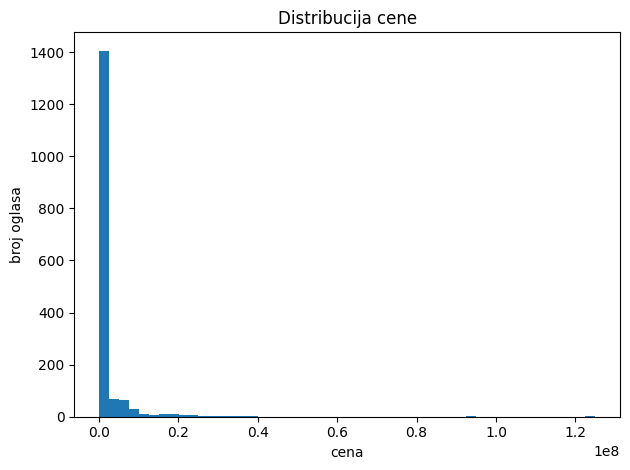

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["selling_price"].dropna(), bins=50)
plt.title("Distribucija cene")
plt.xlabel("cena")
plt.ylabel("broj oglasa")
plt.tight_layout()
plt.show()

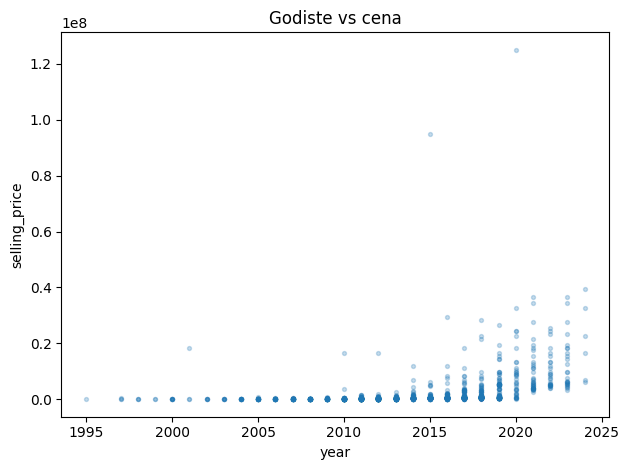

In [6]:
plt.figure()
plt.scatter(df["year"], df["selling_price"], s=8, alpha=0.25)
plt.title("Godiste vs cena")
plt.xlabel("year")
plt.ylabel("selling_price")
plt.tight_layout()
plt.show()

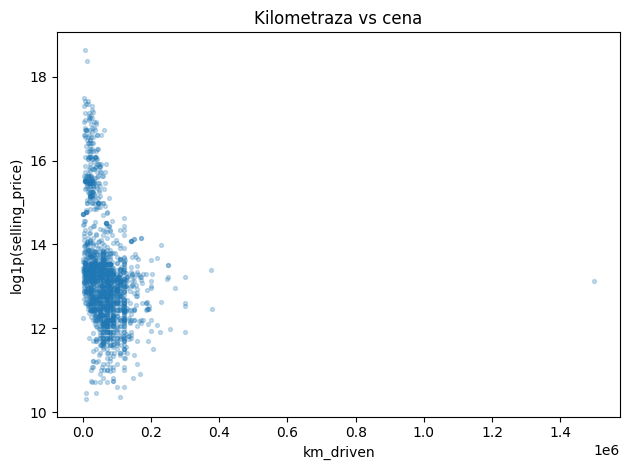

In [7]:
plt.figure()
plt.scatter(df["km_driven"], np.log1p(df["selling_price"]), s=8, alpha=0.25)
plt.title("Kilometraza vs cena")
plt.xlabel("km_driven")
plt.ylabel("log1p(selling_price)")
plt.tight_layout()
plt.show()

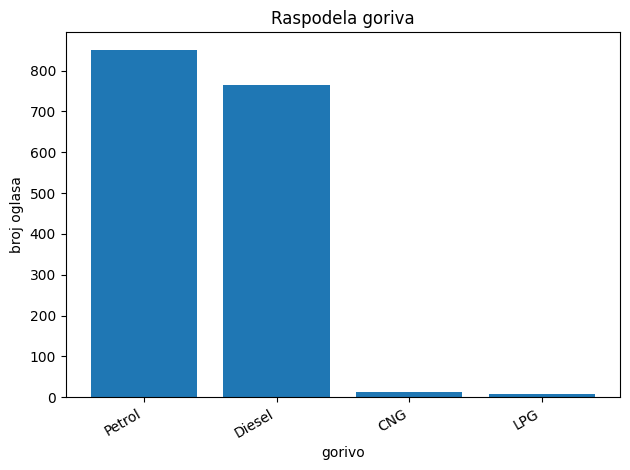

In [8]:
fuel_counts = df["fuel"].value_counts(dropna=False)
plt.figure()
plt.bar(fuel_counts.index.astype(str), fuel_counts.values)
plt.title("Raspodela goriva")
plt.xlabel("gorivo")
plt.ylabel("broj oglasa")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

1. Metan (CNG)
2. Dizel
3. Plin (LPG)
4. Benzin

/var/folders/1z/y0431qm13ys1l9h5w9tslfgw0000gn/T/ipykernel_96062/3924670442.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([non_premium.dropna(), premium.dropna()], labels=["non-premium", "premium"])


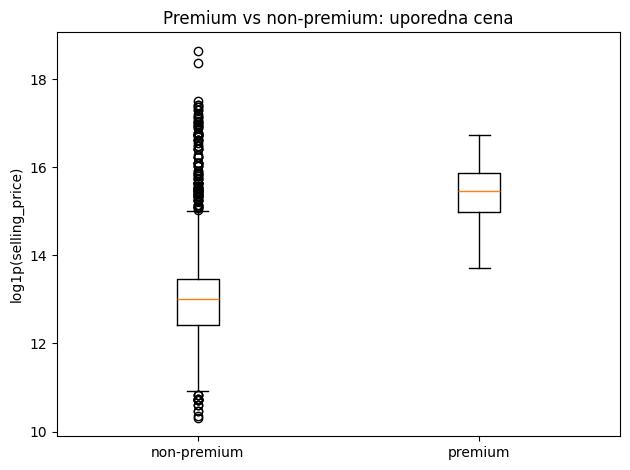

In [9]:
premium = np.log1p(df.loc[df["is_premium_brand"] == 1, "selling_price"])
non_premium = np.log1p(df.loc[df["is_premium_brand"] == 0, "selling_price"])

plt.figure()
plt.boxplot([non_premium.dropna(), premium.dropna()], labels=["non-premium", "premium"])
plt.title("Premium vs non-premium: uporedna cena")
plt.ylabel("log1p(selling_price)")
plt.tight_layout()
plt.show()

### Preprocesiranje/Enkodiranje

In [10]:
from sklearn.preprocessing import MinMaxScaler

# =========================
# CAR (ITEM) FEATURE SPACE
# =========================
CAR_NUM_COLS = [
    "year",
    "selling_price",
    "km_driven",
    "mileage",
    "engine",
    "max_power",
    "torque_nm",
    "seats",
]

CAR_CAT_COLS = ["fuel", "seller_type", "transmission", "owner"]
CAR_BIN_COLS = ["body_suv", "body_sedan", "body_coupe", "is_premium_brand"]

for c in CAR_CAT_COLS:
    df[c] = df[c].fillna("Unknown").astype(str).str.strip()

car_scaler = MinMaxScaler()
df[CAR_NUM_COLS] = car_scaler.fit_transform(df[CAR_NUM_COLS])

car_cat_maps = {}
car_cat_sizes = {}

for c in CAR_CAT_COLS:
    cats = pd.Index(sorted(df[c].unique()))
    if "Unknown" not in cats:
        cats = pd.Index(["Unknown"]).append(cats)
    car_cat_maps[c] = {k: i for i, k in enumerate(cats)}
    car_cat_sizes[c] = len(cats)
    df[c] = df[c].map(car_cat_maps[c]).fillna(car_cat_maps[c]["Unknown"]).astype(int)

num_fuel = car_cat_sizes["fuel"]
num_seller = car_cat_sizes["seller_type"]
num_trans = car_cat_sizes["transmission"]
num_owner = car_cat_sizes["owner"]

def get_car_code(col: str, name: str) -> int:
    return car_cat_maps[col].get(name, car_cat_maps[col]["Unknown"])

petrol_code = get_car_code("fuel", "Petrol")
diesel_code = get_car_code("fuel", "Diesel")

manual_code = get_car_code("transmission", "Manual")
auto_code = get_car_code("transmission", "Automatic")

first_owner_code = get_car_code("owner", "First Owner")
second_owner_code = get_car_code("owner", "Second Owner")

df_items = df[CAR_NUM_COLS + CAR_CAT_COLS + CAR_BIN_COLS].copy()
df_items.head()


,year,selling_price,km_driven,mileage,engine,max_power,torque_nm,seats,fuel,seller_type,transmission,owner,body_suv,body_sedan,body_coupe,is_premium_brand
0,0.620690,0.001920,0.078666,0.738007,0.159749,0.067633,0.081042,0.375,2,2,2,1,0,0,0,0
1,0.620690,0.003121,0.045999,0.686347,0.225645,0.122048,0.153256,0.375,2,2,2,4,0,1,0,0
2,0.689655,0.003241,0.016666,0.641144,0.170732,0.080329,0.048480,0.375,4,2,2,3,0,1,0,0
3,0.689655,0.002961,0.066666,0.519680,0.170732,0.079092,0.047576,0.375,4,2,1,1,0,0,0,0
4,0.689655,0.003521,0.073333,0.817651,0.178006,0.071498,0.102750,0.375,2,2,2,1,0,1,0,0


In [11]:
df_items.isna().sum()

year                0
selling_price       0
km_driven           0
mileage             0
engine              0
max_power           0
torque_nm           0
seats               0
fuel                0
seller_type         0
transmission        0
owner               0
body_suv            0
body_sedan          0
body_coupe          0
is_premium_brand    0
dtype: int64

### Korisnici

In [12]:
# =========================
# USER (DRIVER) DATASET
# =========================
USER_CSV_PATH = "./data/user-details.csv"

users_df = pd.read_csv(USER_CSV_PATH)

# očekivane kolone (driver-like)
REQUIRED_USER_COLS = [
    "age",
    "has_family",
    "annual_km",
    "primary_use",
    "drive_style",
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
    "transmission_pref",
    "fuel_pref",
]

missing = [c for c in REQUIRED_USER_COLS if c not in users_df.columns]
if missing:
    raise ValueError(f"Missing columns in user CSV: {missing}")

# osnovno ciscenje i validacija
users_df["age"] = pd.to_numeric(users_df["age"], errors="coerce")
users_df["has_family"] = pd.to_numeric(users_df["has_family"], errors="coerce")
users_df["annual_km"] = pd.to_numeric(users_df["annual_km"], errors="coerce")

for c in [
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
]:
    users_df[c] = pd.to_numeric(users_df[c], errors="coerce")

# trim stringova
for c in ["primary_use", "drive_style", "transmission_pref", "fuel_pref"]:
    users_df[c] = users_df[c].astype(str).str.strip()

# drop NaN kriticnih
users_df = users_df.dropna(subset=["age", "has_family", "annual_km"]).copy()

# clamp opsega
users_df["age"] = users_df["age"].clip(18, 80).astype(int)
users_df["has_family"] = users_df["has_family"].clip(0, 1).astype(int)
users_df["annual_km"] = users_df["annual_km"].clip(1000, 100000).astype(int)

for c in [
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
]:
    users_df[c] = users_df[c].clip(0.0, 1.0)

# USER feature lists (odvojeno od CAR_*)
USER_NUM_COLS = [
    "age",
    "annual_km",
    "budget_level",
    "comfort_priority",
    "performance_priority",
    "eco_priority",
    "space_need",
    "reliability_priority",
    "offroad_need",
]
USER_BIN_COLS = ["has_family"]
USER_CAT_COLS = ["primary_use", "drive_style", "transmission_pref", "fuel_pref"]

users_df.reset_index(drop=True, inplace=True)
users_df.head()


,age,has_family,annual_km,primary_use,drive_style,budget_level,comfort_priority,performance_priority,eco_priority,space_need,reliability_priority,offroad_need,transmission_pref,fuel_pref
0,56,1,16284,daily,calm,0.82,0.79,0.31,0.66,0.58,0.53,0.25,Manual,Any
1,59,0,7747,daily,normal,0.12,0.44,0.63,1.00,0.55,0.68,0.10,Any,Any
2,21,1,13433,daily,calm,0.35,0.41,0.73,0.97,0.61,0.74,0.00,Automatic,Any
3,59,1,14692,weekend,normal,0.42,0.78,0.50,0.47,0.62,0.28,0.06,Automatic,Any
4,62,0,7568,mixed,calm,0.71,0.83,0.20,0.41,0.53,0.89,0.10,Any,Any


### Bodovanje automobila po segmentima

In [13]:
def _pick_fuel_code_from_pref(fuel_pref: str, annual_km: int) -> int:
    if fuel_pref == "Petrol":
        return petrol_code
    if fuel_pref == "Diesel":
        return diesel_code
    # Any -> heuristika
    return diesel_code if annual_km >= 18000 else petrol_code


def _pick_trans_code_from_pref(trans_pref: str, primary_use: str, comfort: float) -> int:
    if trans_pref == "Manual":
        return manual_code
    if trans_pref == "Automatic":
        return auto_code
    # Any -> heuristika
    if primary_use == "daily" and comfort >= 0.55:
        return auto_code
    return manual_code


def profile_to_car_pref(user_row: pd.Series) -> dict:
    """
    Mapira driver-like user u internu car-preferencu (car feature space).
    Sve numeric vrednosti su u [0,1] da odgovaraju df_items skaliranom sa MinMaxScaler.
    """
    has_family = int(user_row["has_family"])
    annual_km = int(user_row["annual_km"])

    primary_use = str(user_row["primary_use"]).strip()
    drive_style = str(user_row["drive_style"]).strip()

    budget = float(user_row["budget_level"])
    comfort = float(user_row["comfort_priority"])
    perf = float(user_row["performance_priority"])
    eco = float(user_row["eco_priority"])
    space = float(user_row["space_need"])
    rel = float(user_row["reliability_priority"])
    offroad = float(user_row["offroad_need"])

    # target car NUM features (0..1)
    year = np.clip(0.35 + 0.45 * rel + 0.15 * budget + 0.10 * (primary_use == "daily"), 0.0, 1.0)

    # ↓ SMANJENA TEZINA BUDZETA da ne gura Bentley/Rolls svuda
    selling_price = np.clip(0.20 + 0.60 * budget + 0.10 * comfort, 0.0, 1.0)

    km_driven = np.clip(0.55 - 0.25 * rel + 0.20 * (primary_use == "weekend"), 0.0, 1.0)

    mileage = np.clip(0.35 + 0.60 * eco, 0.0, 1.0)
    engine = np.clip(0.20 + 0.70 * perf, 0.0, 1.0)
    max_power = np.clip(0.15 + 0.80 * perf, 0.0, 1.0)
    torque_nm = np.clip(0.20 + 0.75 * perf, 0.0, 1.0)

    seats = np.clip(0.25 + 0.75 * (0.65 * space + 0.35 * has_family), 0.0, 1.0)

    # BIN car prefs (izvedeno)
    body_suv = 1.0 if (offroad >= 0.45 or (space >= 0.65 and has_family == 1)) else 0.0
    body_coupe = 1.0 if (perf >= 0.70 and has_family == 0 and space <= 0.45 and drive_style == "sporty") else 0.0
    body_sedan = 1.0 if (body_suv == 0.0 and body_coupe == 0.0) else 0.0

    # ↓ MANJE agresivan premium signal
    is_premium_brand = 1.0 if (budget >= 0.80 and comfort >= 0.75) else 0.0

    # CAR categorical codes (target preference)
    fuel_code = _pick_fuel_code_from_pref(str(user_row["fuel_pref"]).strip(), annual_km)
    trans_code = _pick_trans_code_from_pref(str(user_row["transmission_pref"]).strip(), primary_use, comfort)

    seller_code = get_car_code("seller_type", "Dealer") if rel >= 0.55 else get_car_code("seller_type", "Individual")
    owner_code = first_owner_code if rel >= 0.55 else second_owner_code

    return {
        "year": float(year),
        "selling_price": float(selling_price),
        "km_driven": float(km_driven),
        "mileage": float(mileage),
        "engine": float(engine),
        "max_power": float(max_power),
        "torque_nm": float(torque_nm),
        "seats": float(seats),
        "fuel": int(fuel_code),
        "seller_type": int(seller_code),
        "transmission": int(trans_code),
        "owner": int(owner_code),
        "body_suv": float(body_suv),
        "body_sedan": float(body_sedan),
        "body_coupe": float(body_coupe),
        "is_premium_brand": float(is_premium_brand),
    }


def score_items_for_user_profile(user_row: pd.Series, cars_df: pd.DataFrame) -> np.ndarray:
    """
    Score svih automobila za jedan driver-like user.
    Vraća score vector (float32).
    """
    pref = profile_to_car_pref(user_row)

    # base numeric similarity u car NUM prostoru
    user_num = np.array([pref[c] for c in CAR_NUM_COLS], dtype="float32")
    car_num = cars_df[CAR_NUM_COLS].values.astype("float32")

    diff = np.abs(car_num - user_num)
    base_sim = np.clip(1.0 - diff, 0.0, 1.0)
    score = base_sim.sum(axis=1).astype("float32")

    # categorical matches
    score += 0.8 * (cars_df["fuel"].values == pref["fuel"]).astype("float32")
    score += 0.6 * (cars_df["transmission"].values == pref["transmission"]).astype("float32")
    score += 0.2 * (cars_df["seller_type"].values == pref["seller_type"]).astype("float32")
    score += 0.2 * (cars_df["owner"].values == pref["owner"]).astype("float32")

    # ↑ POVECAN body signal (da SUV/coupe bude vidljiv)
    score += 2.0 * (cars_df["body_suv"].values.astype("float32") * pref["body_suv"])
    score += 2.0 * (cars_df["body_coupe"].values.astype("float32") * pref["body_coupe"])
    score += 0.8 * (cars_df["body_sedan"].values.astype("float32") * pref["body_sedan"])

    # premium signal slabije
    score += 0.2 * (cars_df["is_premium_brand"].values.astype("float32") * pref["is_premium_brand"])

    return score.astype("float32")


### Generisanje trening parova (pozitivni/negativni)

In [14]:
def generate_training_pairs(users_df, cars_df, n_pos=15, n_neg=15, hard_neg_ratio=0.7):
    # ITEM (cars) tensors
    cars_num = cars_df[CAR_NUM_COLS].values.astype("float32")
    cars_fuel = cars_df["fuel"].values.astype("int32")
    cars_seller = cars_df["seller_type"].values.astype("int32")
    cars_trans = cars_df["transmission"].values.astype("int32")
    cars_owner = cars_df["owner"].values.astype("int32")
    cars_bin = cars_df[CAR_BIN_COLS].values.astype("float32")

    # USER tensors (ali u car-preference prostoru, izvedeno iz driver profila)
    u_num_list, u_fuel_list, u_seller_list, u_trans_list, u_owner_list, u_bin_list = [], [], [], [], [], []
    i_num_list, i_fuel_list, i_seller_list, i_trans_list, i_owner_list, i_bin_list = [], [], [], [], [], []
    y_list = []

    n_items = len(cars_df)
    n_hard = int(n_neg * hard_neg_ratio)
    n_rand = n_neg - n_hard

    for _, user in users_df.iterrows():
        # 1) scoring nad driver-like profilom
        scores = score_items_for_user_profile(user, cars_df)
        idx_sorted = np.argsort(scores)

        # 2) positives: top-N
        pos_idx = idx_sorted[-n_pos:]

        # 3) hard negatives: malo ispod top-N
        hard_pool = (
            idx_sorted[-(n_pos + 200):-n_pos]
            if n_items > (n_pos + 200)
            else idx_sorted[:-n_pos]
        )
        if len(hard_pool) == 0:
            hard_pool = idx_sorted[: max(1, n_items - n_pos)]

        hard_idx = (
            np.random.choice(hard_pool, size=min(n_hard, len(hard_pool)), replace=False)
            if n_hard > 0
            else np.array([], dtype=int)
        )

        # 4) random negatives: ostatak
        rand_pool = np.setdiff1d(np.arange(n_items), pos_idx, assume_unique=False)
        rand_idx = (
            np.random.choice(rand_pool, size=min(n_rand, len(rand_pool)), replace=False)
            if n_rand > 0
            else np.array([], dtype=int)
        )

        neg_idx = np.concatenate([hard_idx, rand_idx])

        # 5) user input za model (izveden car-pref)
        pref = profile_to_car_pref(user)

        u_num = np.array([pref[c] for c in CAR_NUM_COLS], dtype="float32")
        u_fuel = int(pref["fuel"])
        u_seller = int(pref["seller_type"])
        u_trans = int(pref["transmission"])
        u_owner = int(pref["owner"])
        u_bin = np.array([pref[c] for c in CAR_BIN_COLS], dtype="float32")

        def add(indices, label: float):
            for idx in indices:
                u_num_list.append(u_num)
                u_fuel_list.append(u_fuel)
                u_seller_list.append(u_seller)
                u_trans_list.append(u_trans)
                u_owner_list.append(u_owner)
                u_bin_list.append(u_bin)

                i_num_list.append(cars_num[idx])
                i_fuel_list.append(int(cars_fuel[idx]))
                i_seller_list.append(int(cars_seller[idx]))
                i_trans_list.append(int(cars_trans[idx]))
                i_owner_list.append(int(cars_owner[idx]))
                i_bin_list.append(cars_bin[idx])

                y_list.append(float(label))

        add(pos_idx, 1.0)
        add(neg_idx, 0.0)

    return (
        np.stack(u_num_list).astype("float32"),
        np.array(u_fuel_list, dtype="int32"),
        np.array(u_seller_list, dtype="int32"),
        np.array(u_trans_list, dtype="int32"),
        np.array(u_owner_list, dtype="int32"),
        np.stack(u_bin_list).astype("float32"),
        np.stack(i_num_list).astype("float32"),
        np.array(i_fuel_list, dtype="int32"),
        np.array(i_seller_list, dtype="int32"),
        np.array(i_trans_list, dtype="int32"),
        np.array(i_owner_list, dtype="int32"),
        np.stack(i_bin_list).astype("float32"),
        np.array(y_list, dtype="float32"),
    )


### User & Item tornjevi

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model

embedding_dim = 32
num_numeric = len(CAR_NUM_COLS)
num_bin = len(CAR_BIN_COLS)

def emb_dim(n):
    return int(min(16, max(4, round(np.sqrt(n)))))

fuel_emb_dim = emb_dim(num_fuel)
seller_emb_dim = emb_dim(num_seller)
trans_emb_dim = emb_dim(num_trans)
owner_emb_dim = emb_dim(num_owner)

# =========================
# USER tower (car-preference space, derived from driver profile)
# =========================
user_numeric_in = layers.Input(shape=(num_numeric,), name="user_num")
user_bin_in = layers.Input(shape=(num_bin,), name="user_bin")

user_fuel_in = layers.Input(shape=(), dtype="int32", name="user_fuel")
user_seller_in = layers.Input(shape=(), dtype="int32", name="user_seller")
user_trans_in = layers.Input(shape=(), dtype="int32", name="user_trans")
user_owner_in = layers.Input(shape=(), dtype="int32", name="user_owner")

uf_emb = layers.Embedding(num_fuel, fuel_emb_dim)(user_fuel_in)
us_emb = layers.Embedding(num_seller, seller_emb_dim)(user_seller_in)
ut_emb = layers.Embedding(num_trans, trans_emb_dim)(user_trans_in)
uo_emb = layers.Embedding(num_owner, owner_emb_dim)(user_owner_in)

u_concat = layers.Concatenate()([
    user_numeric_in,
    user_bin_in,
    layers.Reshape((fuel_emb_dim,))(uf_emb),
    layers.Reshape((seller_emb_dim,))(us_emb),
    layers.Reshape((trans_emb_dim,))(ut_emb),
    layers.Reshape((owner_emb_dim,))(uo_emb),
])

u_hidden = layers.Dense(128, activation="relu")(u_concat)
u_hidden = layers.Dropout(0.2)(u_hidden)
u_hidden = layers.Dense(64, activation="relu")(u_hidden)
u_vec = layers.Dense(embedding_dim)(u_hidden)
u_vec = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), name="user_l2")(u_vec)

user_tower = Model(
    inputs=[user_numeric_in, user_bin_in, user_fuel_in, user_seller_in, user_trans_in, user_owner_in],
    outputs=u_vec,
    name="user_tower",
)

# =========================
# ITEM tower (car features)
# =========================
item_numeric_in = layers.Input(shape=(num_numeric,), name="item_num")
item_bin_in = layers.Input(shape=(num_bin,), name="item_bin")

item_fuel_in = layers.Input(shape=(), dtype="int32", name="item_fuel")
item_seller_in = layers.Input(shape=(), dtype="int32", name="item_seller")
item_trans_in = layers.Input(shape=(), dtype="int32", name="item_trans")
item_owner_in = layers.Input(shape=(), dtype="int32", name="item_owner")

if_emb = layers.Embedding(num_fuel, fuel_emb_dim)(item_fuel_in)
is_emb = layers.Embedding(num_seller, seller_emb_dim)(item_seller_in)
it_emb = layers.Embedding(num_trans, trans_emb_dim)(item_trans_in)
io_emb = layers.Embedding(num_owner, owner_emb_dim)(item_owner_in)

i_concat = layers.Concatenate()([
    item_numeric_in,
    item_bin_in,
    layers.Reshape((fuel_emb_dim,))(if_emb),
    layers.Reshape((seller_emb_dim,))(is_emb),
    layers.Reshape((trans_emb_dim,))(it_emb),
    layers.Reshape((owner_emb_dim,))(io_emb),
])

i_hidden = layers.Dense(128, activation="relu")(i_concat)
i_hidden = layers.Dropout(0.2)(i_hidden)
i_hidden = layers.Dense(64, activation="relu")(i_hidden)
i_vec = layers.Dense(embedding_dim)(i_hidden)
i_vec = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), name="item_l2")(i_vec)

item_tower = Model(
    inputs=[item_numeric_in, item_bin_in, item_fuel_in, item_seller_in, item_trans_in, item_owner_in],
    outputs=i_vec,
    name="item_tower",
)


### Two Tower model

In [16]:
dot_score = layers.Dot(axes=1, name="dot")([u_vec, i_vec])

model = Model(
    inputs=[
        user_numeric_in, user_bin_in, user_fuel_in, user_seller_in, user_trans_in, user_owner_in,
        item_numeric_in, item_bin_in, item_fuel_in, item_seller_in, item_trans_in, item_owner_in,
    ],
    outputs=dot_score,
    name="two_tower",
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.AUC(from_logits=True, name="auc"),
        tf.keras.metrics.BinaryAccuracy(threshold=0.0, name="acc"),  # 0.0 jer su logiti
    ],
)


model.summary()

Model: "two_tower"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_fuel           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_seller         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_trans          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_owner          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_fuel           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_seller         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_trans          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_owner          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4)         │         20 │ user_fuel[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 4)         │         16 │ user_seller[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 4)         │         12 │ user_trans[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 4)         │         20 │ user_owner[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 4)         │         20 │ item_fuel[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 4)         │         16 │ item_seller[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 4)         │         12 │ item_trans[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 4)         │         20 │ item_owner[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_num            │ (None, 8)         │          0 │ -               

 Total params: 28,232 (110.28 KB)

 Trainable params: 28,232 (110.28 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
(
    u_num,
    u_fuel,
    u_seller,
    u_trans,
    u_owner,
    u_bin,
    i_num,
    i_fuel,
    i_seller,
    i_trans,
    i_owner,
    i_bin,
    y,
) = generate_training_pairs(users_df, df_items, n_pos=15, n_neg=15, hard_neg_ratio=0.7)

history = model.fit(
    [
        u_num, u_bin, u_fuel, u_seller, u_trans, u_owner,
        i_num, i_bin, i_fuel, i_seller, i_trans, i_owner,
    ],
    y,
    epochs=10,
    batch_size=64,
    verbose=1,
    validation_split=0.2,
    shuffle=True,
)


def build_item_inputs_from_df(cars_df: pd.DataFrame):
    num = cars_df[CAR_NUM_COLS].values.astype("float32")
    bin_ = cars_df[CAR_BIN_COLS].values.astype("float32")
    fuel = cars_df["fuel"].values.astype("int32")
    seller = cars_df["seller_type"].values.astype("int32")
    trans = cars_df["transmission"].values.astype("int32")
    owner = cars_df["owner"].values.astype("int32")
    return num, bin_, fuel, seller, trans, owner

item_num_all, item_bin_all, item_fuel_all, item_seller_all, item_trans_all, item_owner_all = build_item_inputs_from_df(df_items)

item_embeddings = item_tower.predict(
    [item_num_all, item_bin_all, item_fuel_all, item_seller_all, item_trans_all, item_owner_all],
    verbose=0,
)


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.7115 - auc: 0.7895 - loss: 0.5824 - val_acc: 0.7450 - val_auc: 0.8185 - val_loss: 0.5553
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.7597 - auc: 0.8393 - loss: 0.5414 - val_acc: 0.7717 - val_auc: 0.8419 - val_loss: 0.5361
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7849 - auc: 0.8608 - loss: 0.5217 - val_acc: 0.7878 - val_auc: 0.8513 - val_loss: 0.5300
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8031 - auc: 0.8816 - loss: 0.5068 - val_acc: 0.7978 - val_auc: 0.8745 - val_loss: 0.5098
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8161 - auc: 0.8945 - loss: 0.4983 - val_acc: 0.7994 - val_auc: 0.8838 - val_loss: 0.5062
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8208 - auc: 0.9005 - loss: 0.4914 - val_acc: 0.8156 - val_auc: 0.8832 - val_loss: 0.5045
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.8260 - auc: 0.9084 - loss: 0.4868 - val

Vidimo da loss pada iz epohe u epohu, sto znaci da model uci i da je stabilan.

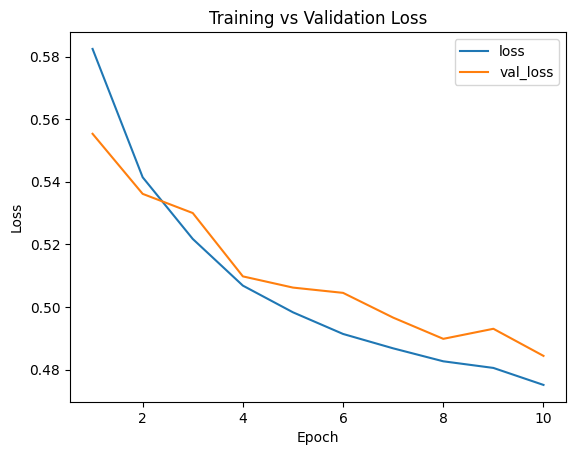

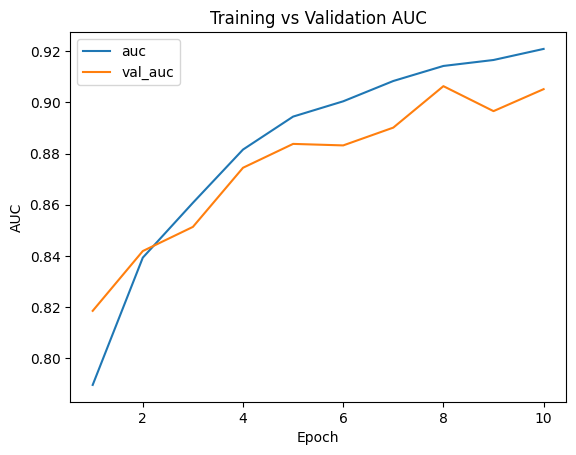

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history["loss"]) + 1)

plt.figure()
plt.plot(epochs, history.history["loss"], label="loss")
if "val_loss" in history.history:
    plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

if "auc" in history.history:
    plt.figure()
    plt.plot(epochs, history.history["auc"], label="auc")
    if "val_auc" in history.history:
        plt.plot(epochs, history.history["val_auc"], label="val_auc")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.title("Training vs Validation AUC")
    plt.legend()
    plt.show()

# proveriti granice za loss epoch (istraziti i videti da li je ovo okej sto krece od 0.65 pa pada do 0.45)
# problem: da se ne udje u overfit
# treba i teorijska i prakticna provera da nismo zagazili u overfitting

### Skorovi za trening parove

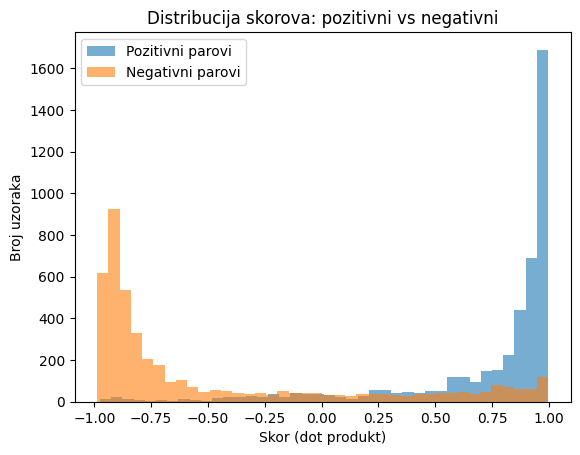

In [19]:
u_emb_train = user_tower.predict(
    [u_num, u_bin, u_fuel, u_seller, u_trans, u_owner],
    verbose=0,
)
i_emb_train = item_tower.predict(
    [i_num, i_bin, i_fuel, i_seller, i_trans, i_owner],
    verbose=0,
)

train_scores = np.sum(u_emb_train * i_emb_train, axis=1)

pos_scores = train_scores[y == 1]
neg_scores = train_scores[y == 0]

import matplotlib.pyplot as plt

plt.figure()
plt.hist(pos_scores, bins=40, alpha=0.6, label="Pozitivni parovi")
plt.hist(neg_scores, bins=40, alpha=0.6, label="Negativni parovi")
plt.xlabel("Skor (dot produkt)")
plt.ylabel("Broj uzoraka")
plt.legend()
plt.title("Distribucija skorova: pozitivni vs negativni")
plt.show()


Vidimo jasno razdvajanje skorova pozitivnih i negativnih parova.

In [20]:
def recommend_for_user_profile(user_profile: dict, top_n=10):
    """
    user_profile: driver-like dict (age, has_family, annual_km, primary_use, ...).
    Interno se mapira na car-preferencu, pa se radi retrieval nad item_embeddings.
    """
    pref = profile_to_car_pref(pd.Series(user_profile))

    user_num = np.array([[pref[c] for c in CAR_NUM_COLS]], dtype="float32")
    user_bin = np.array([[pref[c] for c in CAR_BIN_COLS]], dtype="float32")

    user_fuel = np.array([pref["fuel"]], dtype="int32")
    user_seller = np.array([pref["seller_type"]], dtype="int32")
    user_trans = np.array([pref["transmission"]], dtype="int32")
    user_owner = np.array([pref["owner"]], dtype="int32")

    u_emb = user_tower.predict(
        [user_num, user_bin, user_fuel, user_seller, user_trans, user_owner],
        verbose=0,
    )

    scores = (u_emb @ item_embeddings.T).ravel()
    sorted_idx = np.argsort(scores)[::-1]

    seen_names = set()
    selected_idx = []
    selected_scores = []

    for idx in sorted_idx:
        name = df.iloc[idx]["name"]
        if name not in seen_names:
            seen_names.add(name)
            selected_idx.append(idx)
            selected_scores.append(float(scores[idx]))
        if len(selected_idx) == top_n:
            break

    out = df.iloc[selected_idx][
        ["name", "year", "selling_price", "km_driven", "fuel", "transmission", "owner"]
    ].copy()
    out["score"] = selected_scores
    return out

# def recommend_for_user_profile(
#     user_profile: dict,
#     top_n: int = 10,
#     price_slack: float = 0.15,          # hard budget cap u prostoru [0,1]
#     enforce_body: bool = True,          # penalizuj suprotan body tip
#     min_body_share: float = 0.0,        # npr 0.5 da bar 50% topN bude željeni body
#     diversify: bool = True,             # diversifikacija po brendu
#     brand_cap: int = 3,                 # max auta istog brenda u topN
# ):
#     """
#     Driver-like user_profile -> car preference -> embedding retrieval + hard/soft post-filtering.
#     Vraća top_n unikatnih modela sa skorovima.
#     """
#     pref = profile_to_car_pref(pd.Series(user_profile))

#     # --- user embedding ---
#     user_num = np.array([[pref[c] for c in CAR_NUM_COLS]], dtype="float32")
#     user_bin = np.array([[pref[c] for c in CAR_BIN_COLS]], dtype="float32")

#     user_fuel = np.array([pref["fuel"]], dtype="int32")
#     user_seller = np.array([pref["seller_type"]], dtype="int32")
#     user_trans = np.array([pref["transmission"]], dtype="int32")
#     user_owner = np.array([pref["owner"]], dtype="int32")

#     u_emb = user_tower.predict(
#         [user_num, user_bin, user_fuel, user_seller, user_trans, user_owner],
#         verbose=0,
#     )

#     scores = (u_emb @ item_embeddings.T).ravel().astype("float32")

#     # --- hard budget cap (najbitnije da ne "pobegne" cena) ---
#     if price_slack is not None and price_slack > 0:
#         price_target = float(pref["selling_price"])
#         max_price = min(1.0, price_target + float(price_slack))
#         price_mask = (df_items["selling_price"].values.astype("float32") <= max_price)
#         scores = np.where(price_mask, scores, -1e9)

#     # --- soft body enforcement (penalizuj suprotan body tip) ---
#     if enforce_body:
#         suv_pref = float(pref["body_suv"])
#         coupe_pref = float(pref["body_coupe"])
#         sedan_pref = float(pref["body_sedan"])

#         body_suv = df_items["body_suv"].values.astype("float32")
#         body_coupe = df_items["body_coupe"].values.astype("float32")
#         body_sedan = df_items["body_sedan"].values.astype("float32")

#         # ako preferira SUV -> penalizuj coupe, i obrnuto
#         if suv_pref >= 0.5:
#             scores -= 0.15 * body_coupe
#         if coupe_pref >= 0.5:
#             scores -= 0.20 * body_suv
#             scores -= 0.10 * body_sedan

#         # ako je sedan dominantan, blago penalizuj ekstremne (SUV/coupe)
#         if sedan_pref >= 0.5:
#             scores -= 0.10 * body_suv
#             scores -= 0.10 * body_coupe

#     # --- sortiranje ---
#     sorted_idx = np.argsort(scores)[::-1]

#     # --- selekcija: unikatan naziv + (opciono) limit brenda + (opciono) min_body_share ---
#     seen_names = set()
#     brand_counts = {}

#     want_suv = float(pref["body_suv"]) >= 0.5
#     want_coupe = float(pref["body_coupe"]) >= 0.5
#     want_sedan = (not want_suv) and (not want_coupe) and (float(pref["body_sedan"]) >= 0.5)

#     selected_idx, selected_scores = [], []

#     def brand_of(name: str) -> str:
#         return str(name).split()[0] if isinstance(name, str) and len(name) else "Unknown"

#     def body_ok(idx: int) -> bool:
#         if min_body_share <= 0:
#             return True
#         if want_suv:
#             return int(df_items.iloc[idx]["body_suv"]) == 1
#         if want_coupe:
#             return int(df_items.iloc[idx]["body_coupe"]) == 1
#         if want_sedan:
#             return int(df_items.iloc[idx]["body_sedan"]) == 1
#         return True

#     # 1) prvo pokušaj da ispuniš min_body_share (ako je traženo)
#     body_quota = int(np.ceil(top_n * float(min_body_share)))
#     if body_quota > 0:
#         for idx in sorted_idx:
#             if len(selected_idx) >= body_quota:
#                 break
#             if not body_ok(idx):
#                 continue
#             name = df.iloc[idx]["name"]
#             if name in seen_names:
#                 continue
#             b = brand_of(name)
#             if diversify and brand_counts.get(b, 0) >= brand_cap:
#                 continue
#             if scores[idx] <= -1e8:
#                 continue
#             seen_names.add(name)
#             brand_counts[b] = brand_counts.get(b, 0) + 1
#             selected_idx.append(idx)
#             selected_scores.append(float(scores[idx]))

#     # 2) dopuni do top_n bez body uslova (ili sa blagim)
#     for idx in sorted_idx:
#         if len(selected_idx) == top_n:
#             break
#         name = df.iloc[idx]["name"]
#         if name in seen_names:
#             continue
#         b = brand_of(name)
#         if diversify and brand_counts.get(b, 0) >= brand_cap:
#             continue
#         if scores[idx] <= -1e8:
#             continue
#         seen_names.add(name)
#         brand_counts[b] = brand_counts.get(b, 0) + 1
#         selected_idx.append(idx)
#         selected_scores.append(float(scores[idx]))

#     out = df.iloc[selected_idx][
#         ["name", "year", "selling_price", "km_driven", "fuel", "transmission", "owner"]
#     ].copy()
#     out["score"] = selected_scores

#     # (opciono) prikaz target preferenci radi debug-a
#     out.attrs["user_pref_car_space"] = pref
#     return out



### Test

In [21]:
user_sporty_young = {
    "age": 26,
    "has_family": 0,
    "annual_km": 9000,
    "primary_use": "weekend",
    "drive_style": "sporty",
    "budget_level": 0.70,
    "comfort_priority": 0.45,
    "performance_priority": 0.90,
    "eco_priority": 0.30,
    "space_need": 0.25,
    "reliability_priority": 0.50,
    "offroad_need": 0.05,
    "transmission_pref": "Manual",
    "fuel_pref": "Petrol",
}
recommend_for_user_profile(user_sporty_young, top_n=10)

,name,year,selling_price,km_driven,fuel,transmission,owner,score
1347,Ford Mustang GT Performance,0.862069,0.046171,0.017333,4,2,1,0.968347
824,Chevrolet Camaro LT1 Coupe,0.896552,0.038169,0.019333,4,2,1,0.967892
1350,Chevrolet Corvette Stingray C7,0.724138,0.060575,0.031999,4,2,3,0.965788
822,Ford Mustang Shelby GT350R,0.827586,0.073378,0.018666,4,2,3,0.947323
11,Bentley Continental GT Mulliner,0.931034,0.195807,0.013999,4,1,1,0.920790
384,Bentley Continental GT Speed,0.896552,0.171801,0.015999,4,1,1,0.918193
411,Chevrolet Corvette ZR1,0.827586,0.115788,0.014666,4,1,1,0.916349
1348,Ford Mustang Shelby GT500,0.862069,0.078179,0.013999,4,1,1,0.902583
1602,BMW M4 Coupe,0.724138,0.047771,0.027999,4,2,3,0.882584
382,Aston Martin V12 Vantage,0.931034,0.147795,0.005999,4,2,1,0.839864


In [22]:
user_family = {
    "age": 38,
    "has_family": 1,
    "annual_km": 18000,
    "primary_use": "daily",
    "drive_style": "calm",
    "budget_level": 0.50,
    "comfort_priority": 0.75,
    "performance_priority": 0.40,
    "eco_priority": 0.55,
    "space_need": 0.80,
    "reliability_priority": 0.80,
    "offroad_need": 0.30,
    "transmission_pref": "Automatic",
    "fuel_pref": "Diesel",
}
recommend_for_user_profile(user_family, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
847,Maruti Swift Dzire AMT VXI,0.758621,0.004561,0.017755,4,1,1,0.994264
1460,Toyota Corolla GR Sport Turbo,0.896552,0.030167,0.017333,4,1,1,0.993344
446,MG Hector Sharp DCT Dualtone,0.862069,0.014964,0.001066,4,1,1,0.992912
1095,Toyota Innova Crysta 2.7 GX AT 8 STR,0.862069,0.011763,0.026666,4,1,1,0.988088
242,Jeep Wrangler 2016-2019 3.6 4X4,0.758621,0.032568,0.011333,4,1,1,0.987470
1343,Mercedes-AMG C63 S Sedan,0.758621,0.054173,0.035999,4,1,3,0.985411
1543,Hyundai Creta 1.6 SX Automatic,0.724138,0.006882,0.026666,4,1,1,0.984486
362,Toyota Innova Crysta 2.8 GX AT 8S BSIV,0.793103,0.014163,0.013333,2,1,1,0.982340
451,Skoda Octavia Style Plus 2.0 TDI AT,0.827586,0.020565,0.007333,2,1,1,0.982295
814,Audi S3 Sedan,0.896552,0.033368,0.020666,4,1,3,0.975891


In [23]:
user_budget_city = {
    "age": 29,
    "has_family": 0,
    "annual_km": 11000,
    "primary_use": "daily",
    "drive_style": "normal",
    "budget_level": 0.25,
    "comfort_priority": 0.50,
    "performance_priority": 0.35,
    "eco_priority": 0.70,
    "space_need": 0.40,
    "reliability_priority": 0.60,
    "offroad_need": 0.10,
    "transmission_pref": "Manual",
    "fuel_pref": "Any",
}
recommend_for_user_profile(user_budget_city, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
1199,Honda City i VTEC VX,0.793103,0.007162,0.019266,4,2,1,0.993057
370,Toyota GR Corolla Circuit,0.965517,0.035769,0.005333,4,2,1,0.993054
1200,Honda City 1.5 S MT,0.758621,0.005161,0.033015,4,2,1,0.992991
1536,Honda City i VTEC V,0.724138,0.004761,0.036666,4,2,1,0.991329
1534,Honda City i VTEC SV,0.724138,0.004361,0.036773,4,2,1,0.991327
1531,Honda City i VTEC S,0.689655,0.003761,0.038773,4,2,1,0.989771
1542,Honda City i VTEC VX Option,0.724138,0.005761,0.010767,4,2,1,0.989025
1539,Hyundai Creta 1.6 SX Option,0.793103,0.009162,0.009333,4,2,1,0.987888
1533,Honda City i-VTEC V,0.551724,0.002361,0.026666,4,2,1,0.975473
1213,Hyundai Creta 1.6 SX Option Executive,0.793103,0.011003,0.009999,4,2,1,0.963749


In [24]:
user_offroad = {
    "age": 34,
    "has_family": 1,
    "annual_km": 20000,
    "primary_use": "mixed",
    "drive_style": "normal",
    "budget_level": 0.55,
    "comfort_priority": 0.65,
    "performance_priority": 0.45,
    "eco_priority": 0.50,
    "space_need": 0.75,
    "reliability_priority": 0.70,
    "offroad_need": 0.80,
    "transmission_pref": "Automatic",
    "fuel_pref": "Diesel",
}
recommend_for_user_profile(user_offroad, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
847,Maruti Swift Dzire AMT VXI,0.758621,0.004561,0.017755,4,1,1,0.994548
1460,Toyota Corolla GR Sport Turbo,0.896552,0.030167,0.017333,4,1,1,0.993497
446,MG Hector Sharp DCT Dualtone,0.862069,0.014964,0.001066,4,1,1,0.992161
1095,Toyota Innova Crysta 2.7 GX AT 8 STR,0.862069,0.011763,0.026666,4,1,1,0.987792
242,Jeep Wrangler 2016-2019 3.6 4X4,0.758621,0.032568,0.011333,4,1,1,0.986879
1343,Mercedes-AMG C63 S Sedan,0.758621,0.054173,0.035999,4,1,3,0.986773
1543,Hyundai Creta 1.6 SX Automatic,0.724138,0.006882,0.026666,4,1,1,0.983913
451,Skoda Octavia Style Plus 2.0 TDI AT,0.827586,0.020565,0.007333,2,1,1,0.983842
362,Toyota Innova Crysta 2.8 GX AT 8S BSIV,0.793103,0.014163,0.013333,2,1,1,0.983075
814,Audi S3 Sedan,0.896552,0.033368,0.020666,4,1,3,0.977590


In [25]:
user_premium = {
    "age": 42,
    "has_family": 0,
    "annual_km": 15000,
    "primary_use": "mixed",
    "drive_style": "normal",
    "budget_level": 0.85,
    "comfort_priority": 0.90,
    "performance_priority": 0.55,
    "eco_priority": 0.45,
    "space_need": 0.50,
    "reliability_priority": 0.75,
    "offroad_need": 0.10,
    "transmission_pref": "Automatic",
    "fuel_pref": "Petrol",
}
recommend_for_user_profile(user_premium, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
41,Volkswagen Jetta 2.0L TDI Highline AT,0.724138,0.010563,0.064666,2,1,1,0.986559
1601,BMW M3 Sedan,0.758621,0.046171,0.023999,4,1,1,0.986492
1339,Audi RS3 Sedan,0.896552,0.046971,0.015999,4,1,1,0.984689
392,BMW M340i Sedan,0.862069,0.036569,0.027999,4,1,3,0.984595
814,Audi S3 Sedan,0.896552,0.033368,0.020666,4,1,3,0.981012
1433,BMW 3 Series 320d Sedan,0.551724,0.011763,0.056616,2,1,1,0.980465
451,Skoda Octavia Style Plus 2.0 TDI AT,0.827586,0.020565,0.007333,2,1,1,0.979099
1343,Mercedes-AMG C63 S Sedan,0.758621,0.054173,0.035999,4,1,3,0.977444
406,Mercedes-AMG S63 E Performance,0.965517,0.147795,0.005333,4,1,1,0.967402
847,Maruti Swift Dzire AMT VXI,0.758621,0.004561,0.017755,4,1,1,0.946570


In [26]:
user_high_mileage = {
    "age": 45,
    "has_family": 1,
    "annual_km": 32000,
    "primary_use": "daily",
    "drive_style": "calm",
    "budget_level": 0.60,
    "comfort_priority": 0.70,
    "performance_priority": 0.30,
    "eco_priority": 0.75,
    "space_need": 0.65,
    "reliability_priority": 0.85,
    "offroad_need": 0.15,
    "transmission_pref": "Automatic",
    "fuel_pref": "Diesel",
}
recommend_for_user_profile(user_high_mileage, top_n=10)


,name,year,selling_price,km_driven,fuel,transmission,owner,score
847,Maruti Swift Dzire AMT VXI,0.758621,0.004561,0.017755,4,1,1,0.993884
446,MG Hector Sharp DCT Dualtone,0.862069,0.014964,0.001066,4,1,1,0.993708
1460,Toyota Corolla GR Sport Turbo,0.896552,0.030167,0.017333,4,1,1,0.992755
242,Jeep Wrangler 2016-2019 3.6 4X4,0.758621,0.032568,0.011333,4,1,1,0.988320
1095,Toyota Innova Crysta 2.7 GX AT 8 STR,0.862069,0.011763,0.026666,4,1,1,0.988181
1543,Hyundai Creta 1.6 SX Automatic,0.724138,0.006882,0.026666,4,1,1,0.985166
1343,Mercedes-AMG C63 S Sedan,0.758621,0.054173,0.035999,4,1,3,0.983259
362,Toyota Innova Crysta 2.8 GX AT 8S BSIV,0.793103,0.014163,0.013333,2,1,1,0.981405
451,Skoda Octavia Style Plus 2.0 TDI AT,0.827586,0.020565,0.007333,2,1,1,0.980131
1051,Hyundai Verna VTVT 1.6 AT SX Option,0.827586,0.009922,0.013333,4,1,1,0.975130
